In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sxs
import qnmfits
from qnmfits import utils

Instead of creating our own arrays of fake data, we use as an example an SXS waveform. We pull it apart into a time array and an $h_{\ell, m}$ mode array to demonstrate how one would use a generic waveform array.

In [3]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)

# Transform sxs WaveformModes object to scri WaveformModes for easier array manipulation.
h = utils.sxs_to_scri_WaveformModes(h)

# Shift the times so the peak is now at defined to be at zero
h.t -= h.max_norm_time()

metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')
Mf = metadata.remnant_mass
chif = np.linalg.norm(metadata.remnant_dimensionless_spin)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sxs/catalog/catalog.py:64: UserWarning: 

        You have called a function that uses the `Catalog` class,
        which, as of `sxs` version 2024.0.0, has been deprecated in
        favor of the `Simulations` interface.  See the documentation
        for more information.
        
  warn(deprecation_notice)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


Create a `WaveformModes` object containing only the $(2,2)$ mode using the arrays from above. You will want to start at this step if you already have time and mode arrays. To include more modes, simply add them to the input dictionary.

In [4]:
times = h.t
h_22 = h.data[:,4]

print(type(h_22))

h_wm_22 = utils.dict_to_WaveformModes(times, {(2,2):h_22}, ell_max=2)

<class 'numpy.ndarray'>


In [5]:
# QNMs we want to fit for. The format is (ell, m, n, sign), where sign is +1 
# for "regular" (positive real part) modes, and -1 is for "mirror" (negative 
# real part) modes.
qnms = [(2,2,n,1) for n in range(7+1)]

# Spherical modes we want to fit to. The format is (ell, m).
spherical_modes = [(2,2)]

# Look at different ringdown start times and fit amplitudes at those times.
t0_array = np.linspace(-10, 50, 121)


amp_list = np.zeros((len(t0_array),len(qnms)), complex).T

# Perform the fit
for t, t0 in enumerate(t0_array):
    best_fit_22 = qnmfits.fit(data=h_wm_22,
                              chif=chif, 
                              Mf=Mf,
                              qnms=qnms,
                              spherical_modes=spherical_modes,
                              t0=t0)
    amp_list[:,t] = list(best_fit_22['amplitudes'].values())

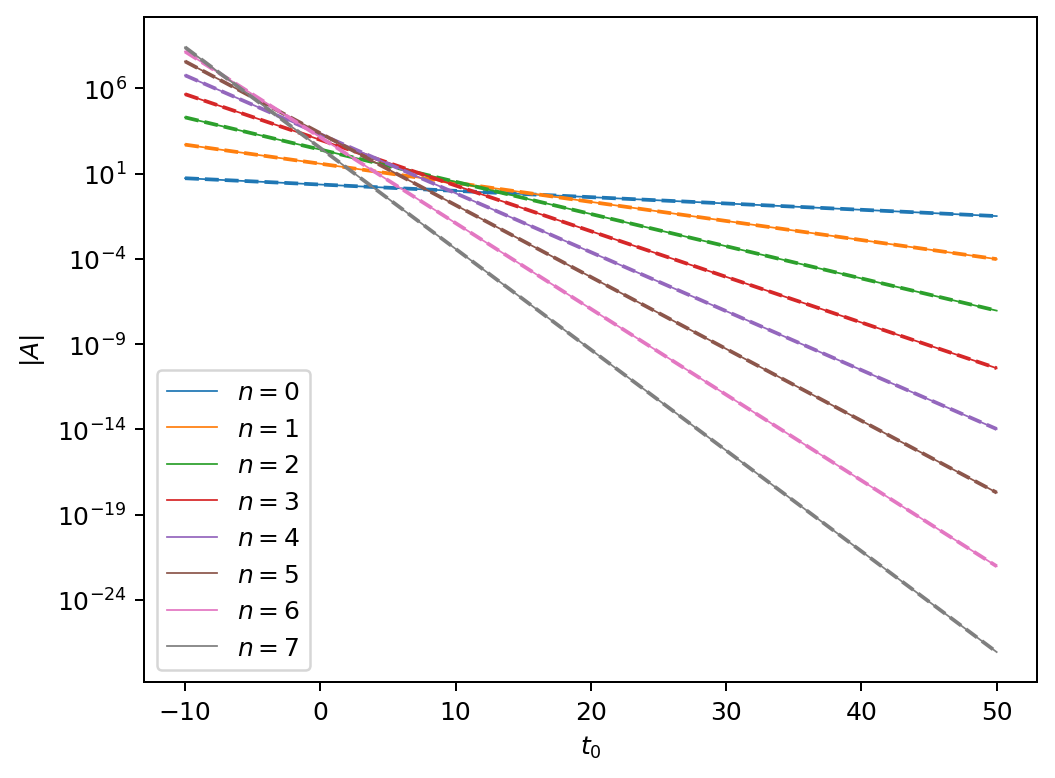

In [6]:
# Plot the best-fit mode amplitudes versus the expected amplitude decay

fig, ax = plt.subplots(dpi=180)
ax.set_yscale('log')

# Find QNM frequencies to use in plotting
frequencies = [qnmfits.qnm_from_tuple(mode, chif, Mf)[0] for mode in qnms]

for n in range(len(qnms)):
    amp_decay = abs(amp_list[n][0]) * np.exp( np.imag(frequencies[n])* t0_array)
    
    ax.plot(t0_array, amp_decay, label=f'$n={n}$',lw=.7)

    # The expected amplitude decay from the QNM frequency
    tau = -1/np.imag(frequencies[n])
    expected_amp = abs(amp_list[n][0])*np.exp(-t0_array/tau)

    ax.plot(t0_array, expected_amp, c=f'C{n}', ls='--')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$|A|$')

_ = ax.legend()